In [26]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [27]:
import os
import pandas as pd

benign_dirs = [
    r'D:/College/LAB/ML lab/The IQ-OTHNCCD lung cancer dataset/Bengin cases'
]

Malignant_dir = [ r'D:/College/LAB/ML lab/The IQ-OTHNCCD lung cancer dataset/Malignant cases']

Normal_dirs = [
    r'D:/College/LAB/ML lab/The IQ-OTHNCCD lung cancer dataset/Normal cases'
]

filepaths = []
labels = []
dict_lists = [benign_dirs, Malignant_dir, Normal_dirs]
class_labels = ['benign', 'Malignant', 'Normal']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Lung_data = pd.concat([Fseries, Lseries], axis=1)
Lung_df = pd.DataFrame(Lung_data)
print(Lung_df.head())
print(Lung_df["labels"].value_counts())

                                           filepaths  labels
0  D:/College/LAB/ML lab/The IQ-OTHNCCD lung canc...  benign
1  D:/College/LAB/ML lab/The IQ-OTHNCCD lung canc...  benign
2  D:/College/LAB/ML lab/The IQ-OTHNCCD lung canc...  benign
3  D:/College/LAB/ML lab/The IQ-OTHNCCD lung canc...  benign
4  D:/College/LAB/ML lab/The IQ-OTHNCCD lung canc...  benign
labels
Malignant    561
Normal       416
benign       120
Name: count, dtype: int64


In [28]:
Lung_df.shape

(1097, 2)

In [29]:
train_images, test_images = train_test_split(Lung_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Lung_df, test_size=0.2, random_state=42)

In [30]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(877, 2)
(330, 2)
(220, 2)
(767, 2)


In [31]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 877 validated image filenames belonging to 3 classes.
Found 330 validated image filenames belonging to 3 classes.
Found 220 validated image filenames belonging to 3 classes.


In [32]:
classes=list(train.class_indices.keys())
print (classes)

['Malignant', 'Normal', 'benign']


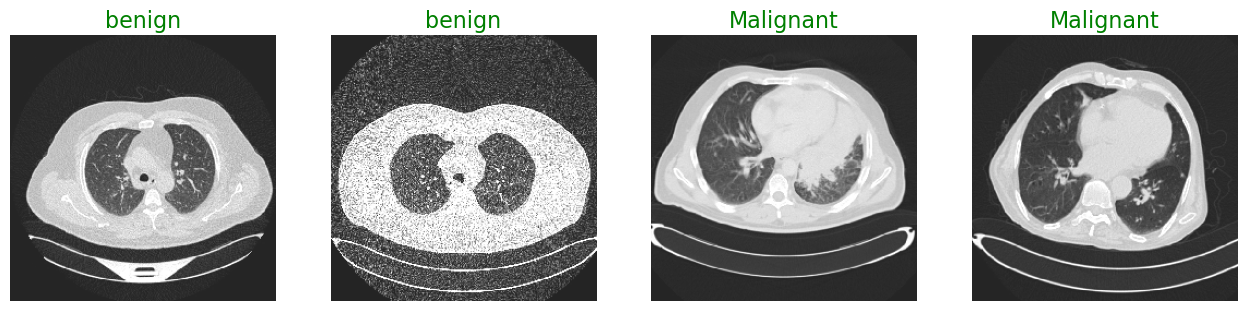

In [33]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [34]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),

    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,610,499 (59.55 MB)

 Trainable params: 15,604,099 (59.52 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [35]:
# ------- Robust Grad-CAM helper (fixed syntax version) -------
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D
import tensorflow as tf
from PIL import Image, ImageOps
from IPython.display import display

def list_conv_candidates(model):
    """Return list of (index, name, class_name, output_shape) for conv-like layers."""
    candidates = []
    for i, layer in enumerate(model.layers):
        cls = layer.__class__.__name__
        if isinstance(layer, (Conv2D, DepthwiseConv2D)) or 'conv' in layer.name.lower() or 'depthwise' in layer.name.lower():
            out_shape = getattr(layer, "output_shape", None)
            candidates.append((i, layer.name, cls, out_shape))
    return candidates

def auto_pick_conv_layer(model):
    """Best-effort pick of a conv layer that has tensor-like (rank 4) output shape."""
    cands = list_conv_candidates(model)
    for idx, name, cls, out_shape in reversed(cands):
        if out_shape is not None and isinstance(out_shape, (tuple, list)) and len(out_shape) == 4:
            return name
    if cands:
        return cands[-1][1]
    return None

def compute_gradcam(img_array, model, last_conv_layer_name):
    """Compute Grad-CAM heatmap for top predicted class given img_array shape (1,H,W,3)."""
    if last_conv_layer_name is None:
        raise ValueError("No convolutional layer name provided for Grad-CAM.")
    try:
        last_conv_layer = model.get_layer(last_conv_layer_name)
    except Exception as e:
        raise RuntimeError(f"Layer {last_conv_layer_name} not found in model: {e}")
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    if grads is None:
        raise RuntimeError("Gradients are None. The chosen layer may not be on the forward path for this input.")
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2)).numpy()
    conv_outputs = conv_outputs[0].numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    return heatmap

def show_gradcam_for_image(pil_img, model, preproc_fn, target_size=(244,244), chosen_layer_name=None):
    """Display candidate layers, auto-select a conv layer and show Grad-CAM overlay for pil_img."""
    print("Conv-like layer candidates (index, name, class, output_shape):")
    cands = list_conv_candidates(model)
    for c in cands:
        print(c)
    if not cands:
        print("No conv-like layers detected. Grad-CAM may not be possible for this model.")
    if chosen_layer_name is None:
        chosen_layer_name = auto_pick_conv_layer(model)
        print("Auto-selected conv layer:", chosen_layer_name)
    else:
        print("Using forced conv layer:", chosen_layer_name)
    x = preproc_fn(pil_img)
    preds = model.predict(x)
    probs = preds[0] if preds.shape[0] == 1 else preds
    if probs.sum() > 1.0 + 1e-6 or probs.min() < 0:
        probs = tf.nn.softmax(probs).numpy()
    top_idx = int(np.argmax(probs))
    print("Top prediction index:", top_idx, "prob:", float(np.max(probs)))
    try:
        heatmap = compute_gradcam(x, model, chosen_layer_name)
    except Exception as e:
        print("Grad-CAM computation failed:", e)
        return
    img_rgb = np.array(ImageOps.fit(pil_img, target_size, Image.BICUBIC)).astype(np.uint8)
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_rgb, 0.6, heatmap_color, 0.4, 0)
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    axs[0].imshow(img_rgb); axs[0].axis('off'); axs[0].set_title("Input")
    axs[1].imshow(overlay); axs[1].axis('off'); axs[1].set_title(f"Grad-CAM: {chosen_layer_name}")
    plt.show()

# Example usage:
# show_gradcam_for_image(pil_img, model, preprocess_image, target_size=(244,244))


In [36]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files (x86)\Graphviz\bin"


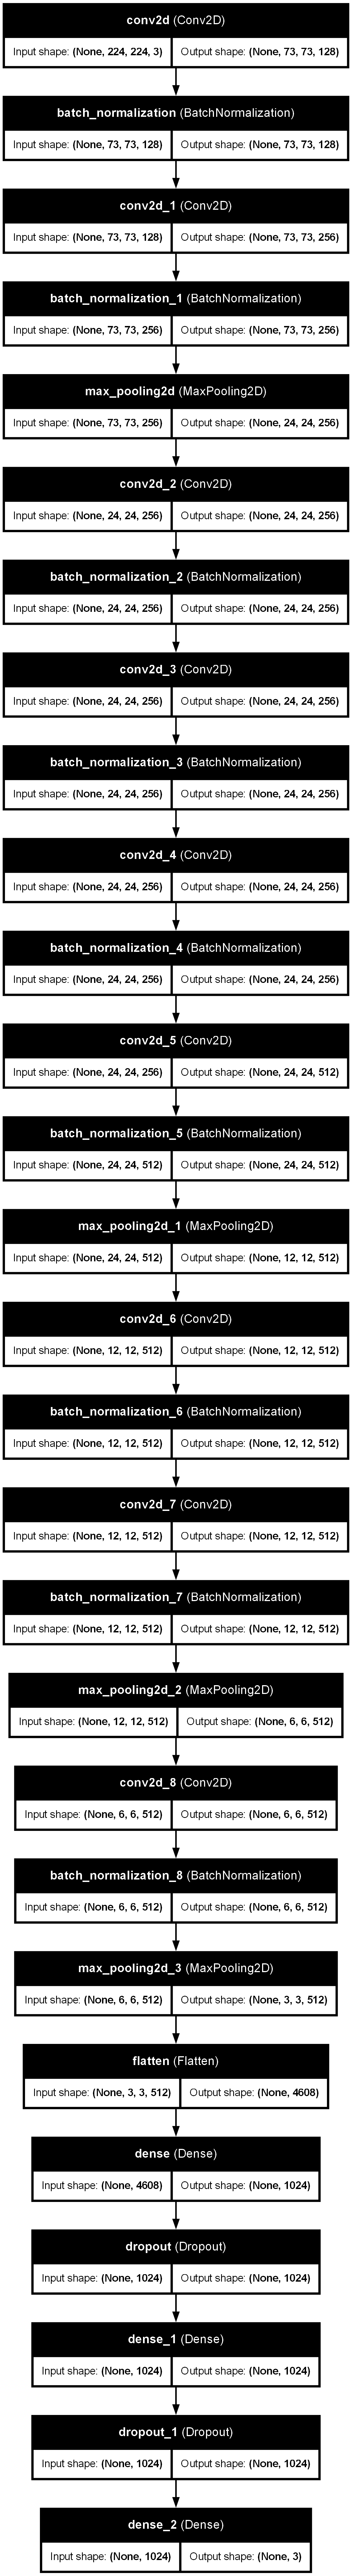

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [38]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 204s 901ms/step - accuracy: 0.5781 - loss: 1.5561 - val_accuracy: 0.4591 - val_loss: 0.9778
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 105s 474ms/step - accuracy: 0.7218 - loss: 0.8502 - val_accuracy: 0.8045 - val_loss: 0.5242
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 108s 489ms/step - accuracy: 0.8119 - loss: 0.5379 - val_accuracy: 0.8864 - val_loss: 0.2723
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 112s 507ms/step - accuracy: 0.8655 - loss: 0.3636 - val_accuracy: 0.8864 - val_loss: 0.2716
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 111s 506ms/step - accuracy: 0.9099 - loss: 0.2412 - val_accuracy: 0.9636 - val_loss: 0.1258
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 111s 506ms/step - accuracy: 0.9350 - loss: 0.1615 - val_accuracy: 0.9864 - val_loss: 0.0720
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 111s 505ms/step - accuracy: 0.9601 - loss: 0.1231 - val_accuracy: 0.9727 - val_loss: 0.0590
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 138s 628ms/step - accuracy: 0.9772 -

In [39]:
model.evaluate(test, verbose=1)

83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.9970 - loss: 0.0168


[0.016797615215182304, 0.9969696998596191]

In [40]:
model.save('lung_cancer_model.keras')

In [41]:
    pred = model.predict(test)
    pred = np.argmax(pred, axis=1) #pick class with highest  probability
    
    labels = (train.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred2 = [labels[k] for k in pred]

83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step


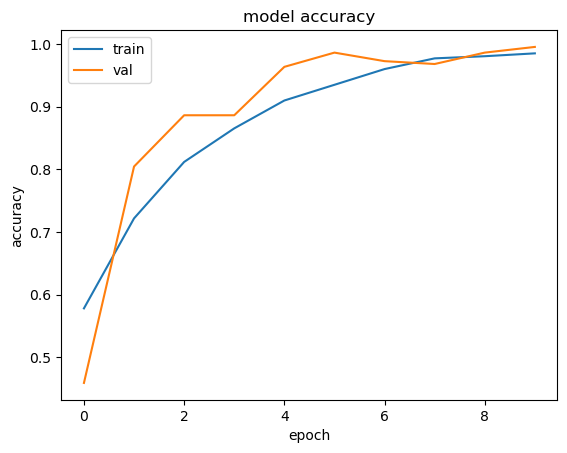

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

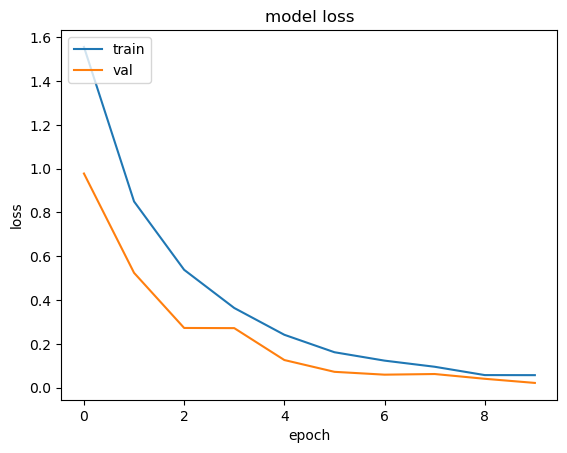

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

   Malignant       1.00      1.00      1.00       174
      Normal       1.00      0.99      1.00       116
      benign       0.98      1.00      0.99        40

    accuracy                           1.00       330
   macro avg       0.99      1.00      0.99       330
weighted avg       1.00      1.00      1.00       330

Accuracy of the Model: 99.7%


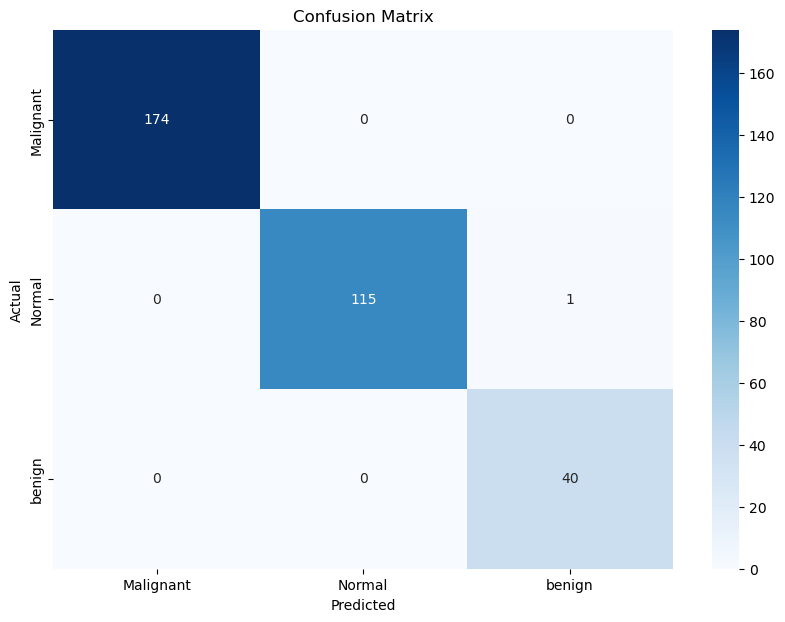

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Malignant', 'Normal', 'benign']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [46]:
!pip install -q tensorflow pillow opencv-python matplotlib ipywidgets

In [47]:
import io, os
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output

# Adapted to values found in your notebook
MODEL_PATH = "lung_cancer_model.keras"   # matches model.save(...) in your notebook
TARGET_SIZE = (244, 244)                # matches the flow_from_dataframe(target_size=(244,244))
# Default class names fallback (will be overwritten if train.class_indices is available)
FALLBACK_CLASS_NAMES = ['benign', 'Malignant', 'Normal']

# Preprocessing used by your ImageDataGenerator in the notebook
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess


In [48]:
def preprocess_image(pil_img, target_size=TARGET_SIZE):
    img = pil_img.convert("RGB")
    img = ImageOps.fit(img, target_size, Image.BICUBIC)
    arr = np.asarray(img).astype(np.float32)
    arr = mobilenet_preprocess(arr)   # matches your ImageDataGenerator(preprocessing_function=...)
    arr = np.expand_dims(arr, 0)
    return arr

def safe_softmax(x):
    x = np.asarray(x, dtype=np.float32)
    if x.ndim == 1:
        x = x - np.max(x)
        ex = np.exp(x)
        return ex / np.sum(ex)
    else:
        x = x - np.max(x, axis=1, keepdims=True)
        ex = np.exp(x)
        return ex / np.sum(ex, axis=1, keepdims=True)

def is_lung_image(pil_img):
    """
    Heuristic validation — same approach I suggested earlier:
    - checks grayscale-ness (not strongly colored),
    - contrast,
    - presence of large dark regions (lungs) using Otsu + contour area.
    Returns (bool, message).
    """
    arr = np.array(pil_img.convert("RGB"))
    # channel difference (colorfulness)
    ch_diff = (np.mean(np.abs(arr[:,:,0].astype(int) - arr[:,:,1].astype(int))) +
               np.mean(np.abs(arr[:,:,0].astype(int) - arr[:,:,2].astype(int)))) / 2.0

    gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape

    if gray.std() < 10:
        return False, "Image has very low contrast — likely not a lung MRI/CT."

    blur = cv2.GaussianBlur(gray, (5,5), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inv = 255 - th
    kernel = np.ones((5,5), np.uint8)
    opening = cv2.morphologyEx(inv, cv2.MORPH_OPEN, kernel, iterations=2)
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large_contours = [c for c in contours if cv2.contourArea(c) > (0.03 * h * w)]

    if len(large_contours) < 1:
        return False, "No large dark regions detected — upload a lung MRI/CT image."

    if ch_diff > 40:
        return False, "Image appears highly colored (photo). Upload a grayscale-like lung scan."

    return True, "Image looks like a lung MRI/CT (heuristic)."


In [49]:
# Load model (uses the filename found in your notebook)
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found: {MODEL_PATH}. Confirm the saved model filename or run the cell that saved the model earlier.")

model = tf.keras.models.load_model(MODEL_PATH)
print("Loaded model:", MODEL_PATH)
print("Model input shape:", model.input_shape)

# Determine class names:
CLASS_NAMES = None
try:
    # If your notebook already has a Keras generator `train` (ImageDataGenerator.flow_from_dataframe),
    # it will include `class_indices`. Use it to build the correct label order.
    if 'train' in globals() and hasattr(train, "class_indices"):
        class_indices = train.class_indices
        # invert mapping: index -> class label
        CLASS_NAMES = [None] * len(class_indices)
        for k, v in class_indices.items():
            CLASS_NAMES[v] = k
        print("Detected CLASS_NAMES from train.class_indices:", CLASS_NAMES)
    else:
        # fallback to class_labels if defined earlier in your notebook
        if 'class_labels' in globals():
            CLASS_NAMES = list(class_labels)
            print("Using class_labels from notebook:", CLASS_NAMES)
        else:
            CLASS_NAMES = FALLBACK_CLASS_NAMES
            print("Using fallback CLASS_NAMES:", CLASS_NAMES)
except Exception as e:
    CLASS_NAMES = FALLBACK_CLASS_NAMES
    print("Error while detecting class names; using fallback:", CLASS_NAMES, " (error:", e, ")")


Loaded model: lung_cancer_model.keras
Model input shape: (None, 224, 224, 3)
Detected CLASS_NAMES from train.class_indices: ['Malignant', 'Normal', 'benign']


In [50]:
def make_gradcam(img_array, model, last_conv_layer_name=None):
    """
    Return heatmap (0..1) for the top predicted class using Grad-CAM.
    img_array: preprocessed (1,H,W,3)
    """
    # find a conv layer if not specified
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if hasattr(layer, "output") and ("conv" in layer.name or "Conv" in layer.__class__.__name__):
                last_conv_layer_name = layer.name
                break
    if last_conv_layer_name is None:
        raise ValueError("No convolutional layer found for Grad-CAM.")

    last_conv_layer = model.get_layer(last_conv_layer_name)
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0].numpy()
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
    return heatmap


In [56]:
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(widgets.HTML("<h3>Upload lung MRI/CT image</h3>"))
display(uploader)

out = widgets.Output()
display(out)

def on_upload_change(change):
    out.clear_output()
    if len(uploader.value) == 0:
        return
    uploaded_filename = list(uploader.value.keys())[0]
    content = uploader.value[uploaded_filename]['content']
    try:
        pil_img = Image.open(io.BytesIO(content)).convert("RGB")
    except Exception as e:
        with out:
            print("Cannot open uploaded file as image:", e)
        return

    with out:
        clear_output(wait=True)
        display(pil_img.resize((400,400)))
        valid, message = is_lung_image(pil_img)
        if not valid:
            print("Validation warning:", message)
            return
        else:
            print("Validation:", message)

        x = preprocess_image(pil_img, TARGET_SIZE)
        preds = model.predict(x)[0]
        if preds.sum() <= 1.0 + 1e-6 and preds.min() >= 0:
            probs = preds
        else:
            probs = safe_softmax(preds)
        top_idx = int(np.argmax(probs))
        top_label = CLASS_NAMES[top_idx] if top_idx < len(CLASS_NAMES) else f"Class {top_idx}"
        confidence = float(probs[top_idx])

        print(f"Prediction: {top_label} (confidence: {confidence*100:.2f}%)")
        print("\nAll class probabilities:")
        for i,p in enumerate(probs):
            label = CLASS_NAMES[i] if i < len(CLASS_NAMES) else f"Class {i}"
            print(f" - {label}: {p*100:.2f}%")

        # Grad-CAM visualization
        try:
            heatmap = make_gradcam(x, model)
            img_rgb = np.array(ImageOps.fit(pil_img, TARGET_SIZE, Image.BICUBIC)).astype(np.uint8)
            heatmap_uint8 = np.uint8(255 * heatmap)
            heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
            heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
            overlay = cv2.addWeighted(img_rgb, 0.6, heatmap_color, 0.4, 0)

            fig, axes = plt.subplots(1,2, figsize=(10,5))
            axes[0].imshow(img_rgb); axes[0].set_title("Preprocessed input"); axes[0].axis('off')
            axes[1].imshow(overlay); axes[1].set_title("Grad-CAM overlay"); axes[1].axis('off')
            plt.show()
        except Exception as e:
            print("Grad-CAM failed:", e)

uploader.observe(on_upload_change, names='value')


HTML(value='<h3>Upload lung MRI/CT image</h3>')

FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [60]:
import io
from PIL import Image

# Check the uploaded file dictionary
uploader.value


({'name': 'images (3).jpeg',
  'type': 'image/jpeg',
  'size': 9021,
  'content': <memory at 0x00000272109D2500>,
  'last_modified': datetime.datetime(2025, 11, 13, 4, 58, 51, 836000, tzinfo=datetime.timezone.utc)},)

✅ Saved uploaded file to: images (3).jpeg


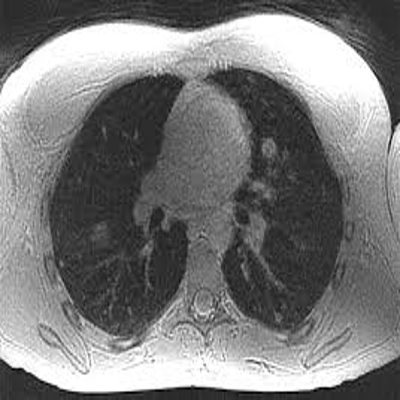

In [61]:
import io
from PIL import Image

# ---- handle both possible formats safely ----
if isinstance(uploader.value, tuple) and len(uploader.value) > 0:
    # New ipywidgets format: tuple of dicts
    upload_obj = uploader.value[0]
    uploaded_filename = upload_obj['name']
    content = upload_obj['content']
elif isinstance(uploader.value, dict) and len(uploader.value) > 0:
    # Older format: dict of dicts
    uploaded_filename = list(uploader.value.keys())[0]
    content = uploader.value[uploaded_filename]['content']
else:
    raise ValueError("⚠️ No file uploaded yet — please upload an image first.")

# ---- save file to disk ----
save_path = uploaded_filename  # or use "uploads/" + uploaded_filename
with open(save_path, "wb") as f:
    f.write(content)

print("✅ Saved uploaded file to:", save_path)

# optional: verify image
img = Image.open(save_path)
display(img.resize((400, 400)))


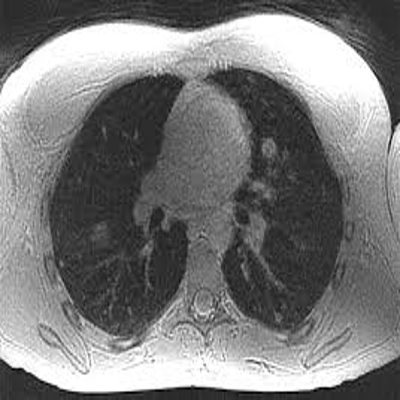

Validation: Image looks like a lung MRI/CT (heuristic).
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Prediction: Malignant (confidence: 50.09%)
All class probabilities:
 - Malignant: 50.09%
 - Normal: 45.88%
 - benign: 4.03%
Grad-CAM failed: The layer sequential has never been called and thus has no defined output.


In [62]:
# Replace this path if your uploaded file moved
uploaded_path = r"C:\Users\USER\images (3).jpeg"

from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# Ensure helper funcs + model exist; if not, load model and define preprocess/is_lung_image as before
try:
    model  # use existing model if present
except NameError:
    MODEL_PATH = "lung_cancer_model.keras"
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Model not found at {MODEL_PATH}. Either load model in memory or place it at this path.")
    import tensorflow as tf
    model = tf.keras.models.load_model(MODEL_PATH)
    print("Loaded model from", MODEL_PATH)

# Ensure preprocessing function exists; otherwise define the same as earlier:
try:
    preprocess_image
    is_lung_image
    make_gradcam
    safe_softmax
except NameError:
    # Minimal fallback definitions matching your notebook settings
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
    def preprocess_image(pil_img, target_size=(244,244)):
        img = pil_img.convert("RGB")
        img = ImageOps.fit(img, target_size, Image.BICUBIC)
        arr = np.asarray(img).astype(np.float32)
        arr = mobilenet_preprocess(arr)
        arr = np.expand_dims(arr, 0)
        return arr

    def safe_softmax(x):
        x = np.asarray(x, dtype=np.float32)
        x = x - np.max(x)
        ex = np.exp(x)
        return ex / np.sum(ex)

    def is_lung_image(pil_img):
        arr = np.array(pil_img.convert("RGB"))
        ch_diff = (np.mean(np.abs(arr[:,:,0].astype(int) - arr[:,:,1].astype(int))) +
                   np.mean(np.abs(arr[:,:,0].astype(int) - arr[:,:,2].astype(int)))) / 2.0
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        if gray.std() < 10:
            return False, "Image has very low contrast — likely not a lung MRI/CT."
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        inv = 255 - th
        kernel = np.ones((5,5), np.uint8)
        opening = cv2.morphologyEx(inv, cv2.MORPH_OPEN, kernel, iterations=2)
        contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        h,w = gray.shape
        large_contours = [c for c in contours if cv2.contourArea(c) > (0.03 * h * w)]
        if len(large_contours) < 1:
            return False, "No large dark regions detected — upload a lung MRI/CT image."
        if ch_diff > 40:
            return False, "Image appears highly colored (photo). Upload a grayscale-like lung scan."
        return True, "Image looks like a lung MRI/CT (heuristic)."

    # Grad-CAM fallback (attempt)
    import tensorflow as tf
    def make_gradcam(img_array, model, last_conv_layer_name=None):
        if last_conv_layer_name is None:
            for layer in reversed(model.layers):
                if 'conv' in layer.name or 'Conv' in layer.__class__.__name__:
                    last_conv_layer_name = layer.name
                    break
        if last_conv_layer_name is None:
            raise ValueError("No conv layer found for Grad-CAM.")
        last_conv_layer = model.get_layer(last_conv_layer_name)
        grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])
        with tf.GradientTape() as tape:
            conv_outputs, predictions = grad_model(img_array)
            pred_index = tf.argmax(predictions[0])
            class_channel = predictions[:, pred_index]
        grads = tape.gradient(class_channel, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
        conv_outputs = conv_outputs[0].numpy()
        pooled_grads = pooled_grads.numpy()
        for i in range(pooled_grads.shape[-1]):
            conv_outputs[:,:,i] *= pooled_grads[i]
        heatmap = np.mean(conv_outputs, axis=-1)
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
        heatmap = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
        return heatmap

# Load and show image
pil_img = Image.open(uploaded_path).convert("RGB")
display(pil_img.resize((400,400)))

# Validate
valid, msg = is_lung_image(pil_img)
print("Validation:", msg)
if not valid:
    raise RuntimeError("Validation failed — please upload a lung MRI/CT image.")

# Preprocess and predict
x = preprocess_image(pil_img, target_size=(244,244))
preds = model.predict(x)[0]
if preds.sum() <= 1.0 + 1e-6 and preds.min() >= 0:
    probs = preds
else:
    probs = safe_softmax(preds)

# Attempt to get class names from notebook variables if available
try:
    CLASS_NAMES
except NameError:
    # fallback mapping
    CLASS_NAMES = ['benign', 'Malignant', 'Normal']

top_idx = int(np.argmax(probs))
top_label = CLASS_NAMES[top_idx] if top_idx < len(CLASS_NAMES) else f"Class {top_idx}"
confidence = float(probs[top_idx])

print(f"Prediction: {top_label} (confidence: {confidence*100:.2f}%)")
print("All class probabilities:")
for i,p in enumerate(probs):
    label = CLASS_NAMES[i] if i < len(CLASS_NAMES) else f"Class {i}"
    print(f" - {label}: {p*100:.2f}%")

# Grad-CAM overlay
try:
    heatmap = make_gradcam(x, model)
    img_rgb = np.array(ImageOps.fit(pil_img, (244,244), Image.BICUBIC)).astype(np.uint8)
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img_rgb, 0.6, heatmap_color, 0.4, 0)
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(img_rgb); axes[0].set_title("Preprocessed input"); axes[0].axis('off')
    axes[1].imshow(overlay); axes[1].set_title("Grad-CAM overlay"); axes[1].axis('off')
    plt.show()
except Exception as e:
    print("Grad-CAM failed:", e)
